In [ ]:
# Goal: for each chosen time period, create a plot with profitability on the x-axis, and predictability on the y-axis.

In [1]:
# if "preprocessing" folder in current folders -> cd back to original folder
%cd /content
import os
if os.path.exists("bsc-thesis"):
  # if bsc-thesis folder already exists; completely remove
  !rm -rf bsc-thesis

# this makes sure cached files are readily available (for calling e.g. `gather_data_cached`)
!apt-get install git-lfs
!git lfs install

# cloning repo
branch = "main"
!git clone --branch $branch https://github.com/maviddoerdijk/bsc-thesis.git

# moving into project dir
%cd bsc-thesis/src
%ls

/content
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git-lfs is already the newest version (3.0.2-1ubuntu0.3).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
Git LFS initialized.
Cloning into 'bsc-thesis'...
remote: Enumerating objects: 624, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 624 (delta 0), reused 0 (delta 0), pack-reused 620 (from 1)
Receiving objects: 100% (624/624), 23.52 MiB | 21.05 MiB/s, done.
Resolving deltas: 100% (354/354), done.
Filtering content: 100% (14/14), 1.75 GiB | 156.10 MiB/s, done.
/content/bsc-thesis/src
backtesting/  data/      main.ipynb  models/         utils/
config/       external/  main.py     preprocessing/


In [2]:
!pip install numpy==1.26.3 # necessary for bug fix
!pip install peft==0.10.0
!pip install ta
!pip install pykalman
!pip install PyWavelets
!pip install curl-cffi

## specific packages for time moe
# need a different version of accelerate because of bug "ImportError: cannot import name 'clear_device_cache' from 'accelerate.utils.memory'"
!pip install -U accelerate==0.32.0 # standard google colab version is 1.6.0 (apr 1, 2025), but for stability, we use time moe's 0.28.0 (mar 12, 2024)
!pip install transformers==4.40.1 # standard google colab version is 4.51.3, but time moe repo requirements mention/prefer 4.40.1 for stability
!pip install datasets==2.18.0
FLASH_ATTN = False # set to true if using this
if FLASH_ATTN:
  !pip install flash-attn==2.6.3 # optional but recommended by the repo

In [3]:
# Module imports
import pandas as pd
import numpy as np
from typing import Optional, Callable, Dict, Any
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.utils.data import DataLoader
from tqdm.auto import tqdm # note: using tqdm.auto usually automatically chooses the right import based on whether you're in CLI, notebook or somewhere else
import torch.nn as nn
import itertools
from pykalman import KalmanFilter
import ast
import re
from tabulate import tabulate
from datetime import datetime

# Custom Imports
from models.statistical_models import create_dataset, default_normalize, rmse_metric, acc_metric, kalman_filter_average, kalman_filter_regression, kalman_filter_regression_multivariate
from preprocessing.cointegration import find_cointegrated_pairs
from preprocessing.data_preprocessing import filter_pairs_data
from preprocessing.technical_indicators import combine_pairs_data
from preprocessing.wavelet_denoising import wav_den
from preprocessing.filters import step_1_filter_remove_nans, step_2_filter_liquidity
from backtesting.trading_strategy import trade
from backtesting.utils import calculate_return_uncertainty
from utils.visualization import plot_return_uncertainty, plot_comparison

# important for time moe
import wandb
wandb.login()

## workflow imports
from models.statistical_models import execute_kalman_workflow
from models.transformer_model import execute_transformer_workflow
from models.time_moe_model import execute_timemoe_workflow

## specific caching imports (should be changed in case you want to gather data live)
from data.scraper import load_cached_etf_tickers
from data.data_collection_cache import gather_data_cached, _get_filename

# Any other changes to be made throughout the entire notebook
plt.style.use('seaborn-v0_8')

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: davidmoerdijk (davidmoerdijk-smart-backoffice) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


# 1. Create the profitability-predictability plot for our best time period: 2008-2018


In [4]:
startDateStr = '2008-10-01'
endDateStr = '2018-10-02' # documentation said that endDateStr is exclusive for both yahoofinance and the original code, but actually printing the shapes showed otherwise..
instrumentIdsNASDAQandNYSE = load_cached_etf_tickers()
data = gather_data_cached(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE, cache_dir='../src/data/cache')
data_close_filtered_1, data_open_filtered_1, data_high_filtered_1, data_low_filtered_1, data_vol_filtered_1, data_original_format_filtered_1 = step_1_filter_remove_nans(data['close'], data['open'], data['high'], data['low'], data['vol'], data)
data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, data_original_format_filtered_2 = step_2_filter_liquidity(data_close_filtered_1, data_open_filtered_1, data_high_filtered_1, data_low_filtered_1, data_vol_filtered_1, data_original_format_filtered_1)

scores, pvalues, pairs = find_cointegrated_pairs(data_original_format_filtered_2) # note, from all 820 pairs, only 95 are returned, because we filter out all pairs that have a cointegration score <0.05
pairs_data = {key:value[1]  for (key, value) in pairs.items()}
pairs_data = sorted(pairs_data.items(), key=lambda x: x[1])
pairs_data_filtered = filter_pairs_data(pairs_data)

Processing pairs: 100%|██████████| 820/820 [01:47<00:00,  7.60it/s]

Completed 820 pairs


In [12]:
## Data gathering
# for each pair, we want the tuple (gt_yoy, val_mse_kalman_excl)
pairs_data_filtered
results = []
for i in tqdm(range(len(pairs_data_filtered)), desc = "Gathering val MSE and ground truth returns for different pairs.."):
    ticker_a, ticker_b = pairs_data_filtered[i][0][0], pairs_data_filtered[i][0][1]
    pairs_timeseries_df = combine_pairs_data(data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, ticker_a, ticker_b)
    pair_tup_str = f"({ticker_a},{ticker_b})"
    output = execute_kalman_workflow(pair_data=pairs_timeseries_df, verbose=False, pair_tup_str=pair_tup_str, add_technical_indicators=False) # very important detail: add_technical_indicators must be true, because that form is a much more reliable form of Kalman Filtering!
    results.append((pair_tup_str, output['gt_yoy'], output['val_mse'])) # tuples of form (pair_tup_str, gt_yoy, val_mse_kalman_excl)

Gathering val MSE and ground truth returns for different pairs..:   0%|          | 0/95 [00:00<?, ?it/s]

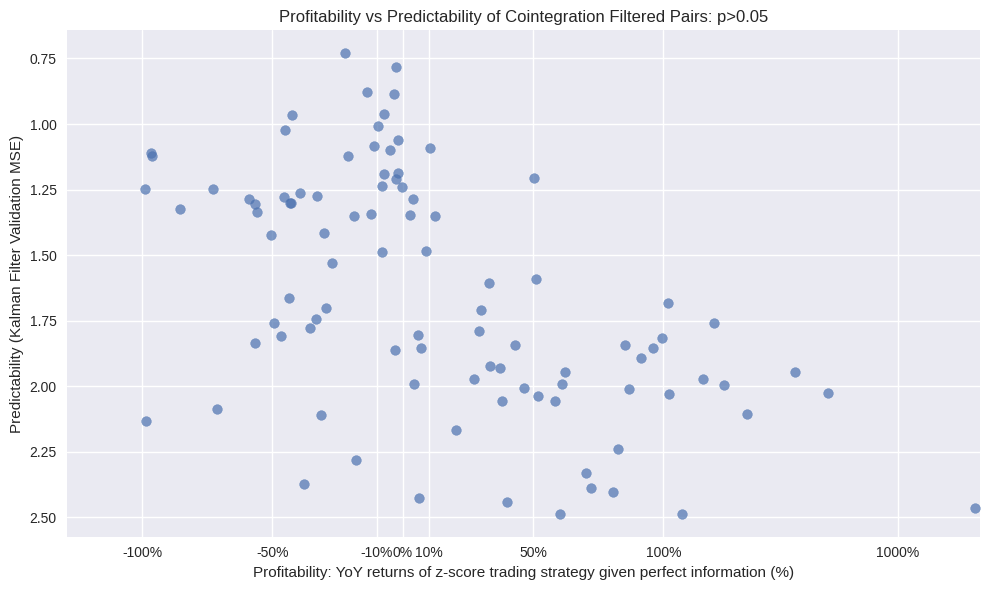

In [30]:
# plotting
import matplotlib.pyplot as plt

pair_names = [r[0] for r in results]
profitability = [r[1] * 100 for r in results]  # gt_yoy
predictability = [r[2] for r in results]  # val_mse
plt.figure(figsize=(10, 6))
plt.scatter(profitability, predictability, alpha=0.7)
plt.xlabel("Profitability: YoY returns of z-score trading strategy given perfect information (%)")
plt.ylabel("Predictability (Kalman Filter Validation MSE)")
plt.title("Profitability vs Predictability of Cointegration Filtered Pairs: p>0.05")
plt.gca().invert_yaxis() # invert y-axis, because lower MSE is better
plt.xscale('symlog', linthresh=100)  # use log for outliers, because some percentages go to 2000%, but most are between-50% and 50%
plt.xticks([-100, -50, -10, 0, 10, 50, 100, 1000], ['-100%', '-50%', '-10%', '0%', '10%', '50%', '100%', '1000%'])

# optional: annotate pairs
# for i, name in enumerate(pair_names):
#     plt.annotate(name, (profitability[i], predictability[i]), fontsize=8, alpha=0.6)

plt.grid(True)
plt.tight_layout()
plt.show()

# most negative profitability
most_negative_profitability = min(profitability) # -98, because we can't lose more than 100% of course!

Gathering val MSE and ground truth returns for different pairs..:   0%|          | 0/95 [00:00<?, ?it/s]

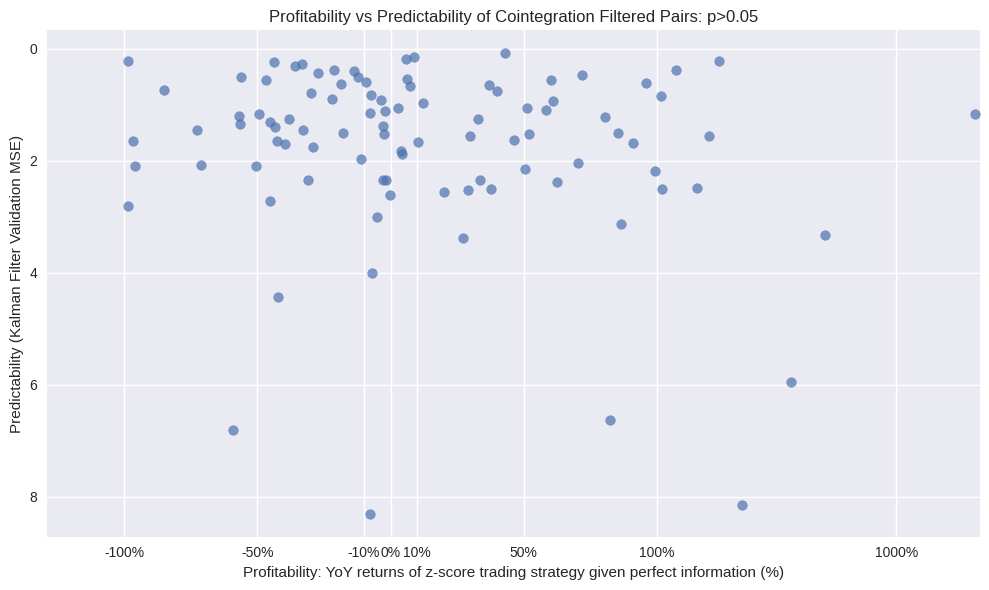

In [31]:
"""
A big quirk is still that the MSE seems rather bad. We'd want to get closer to MSE of 0.00x
Let's quickly retry using add_technical_indicators=True

"""
## Data gathering
# for each pair, we want the tuple (gt_yoy, val_mse_kalman_excl)
pairs_data_filtered
results = []
for i in tqdm(range(len(pairs_data_filtered)), desc = "Gathering val MSE and ground truth returns for different pairs.."):
    ticker_a, ticker_b = pairs_data_filtered[i][0][0], pairs_data_filtered[i][0][1]
    pairs_timeseries_df = combine_pairs_data(data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, ticker_a, ticker_b)
    pair_tup_str = f"({ticker_a},{ticker_b})"
    output = execute_kalman_workflow(pair_data=pairs_timeseries_df, verbose=False, pair_tup_str=pair_tup_str, add_technical_indicators=True) # very important detail: add_technical_indicators must be true, because that form is a much more reliable form of Kalman Filtering!
    results.append((pair_tup_str, output['gt_yoy'], output['val_mse'])) # tuples of form (pair_tup_str, gt_yoy, val_mse_kalman_excl)

# plotting
import matplotlib.pyplot as plt

pair_names = [r[0] for r in results]
profitability = [r[1] * 100 for r in results]  # gt_yoy
predictability = [r[2] for r in results]  # val_mse
plt.figure(figsize=(10, 6))
plt.scatter(profitability, predictability, alpha=0.7)
plt.xlabel("Profitability: YoY returns of z-score trading strategy given perfect information (%)")
plt.ylabel("Predictability (Kalman Filter Validation MSE)")
plt.title("Profitability vs Predictability of Cointegration Filtered Pairs: p>0.05")
plt.gca().invert_yaxis() # invert y-axis, because lower MSE is better
plt.xscale('symlog', linthresh=100)  # use log for outliers, because some percentages go to 2000%, but most are between-50% and 50%
plt.xticks([-100, -50, -10, 0, 10, 50, 100, 1000], ['-100%', '-50%', '-10%', '0%', '10%', '50%', '100%', '1000%'])

# optional: annotate pairs
# for i, name in enumerate(pair_names):
#     plt.annotate(name, (profitability[i], predictability[i]), fontsize=8, alpha=0.6)

plt.grid(True)
plt.tight_layout()
plt.show()

# most negative profitability
most_negative_profitability = min(profitability) # -98, because we can't lose more than 100% of course!

#2. Create the caching for pairs data, AFTER doing cointegration tests


#3. Create plots for all other pairs